In [223]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
import pydotplus
from sklearn.model_selection import KFold
from IPython.display import Image  
from sklearn.tree import export_graphviz

In [224]:
training_df = pd.read_csv("./training_preprocessed.csv")
test_df = pd.read_csv("./test_preprocessed.csv")
y = training_df['Target']
training_df = training_df.drop('Target', axis=1)

# Balancing unbalanced data

First of all, we will make sure that the training data is balanced, we will use the ADASYN algorithm for oversampling the minority class and then we will use the Tomek-Link algorithm for undersampling the majority class

In [225]:
oversample = ADASYN(random_state = 1)
training_df, y = oversample.fit_resample(training_df, y)
adasyn_data = pd.concat([pd.DataFrame(training_df),pd.DataFrame(y, columns=['Target'])], axis=1)
print(adasyn_data['Target'].value_counts())

0    425
1    420
Name: Target, dtype: int64


In [226]:

# Create an instance of TomekLinks with the defined parameters
tomek_links = TomekLinks(sampling_strategy='auto')

# Apply Tomek Links to the dataset
X_resampled, y_resampled = tomek_links.fit_resample(training_df, y)

# Convert the resampled data back to pandas DataFrame and Series if needed
training_df = pd.DataFrame(X_resampled, columns=training_df.columns)
y = pd.Series(y_resampled)
print(y.value_counts())

1    420
0    370
Name: Target, dtype: int64


Making simple decisionTreeClassifier with cross validation method

In [227]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)

# Initialize the decision tree classifier
DTC = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
DTC.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = DTC.predict(X_test)

# Calculate the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy Score:", accuracy)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7272727272727273


,0,1
0,60,29
1,25,84


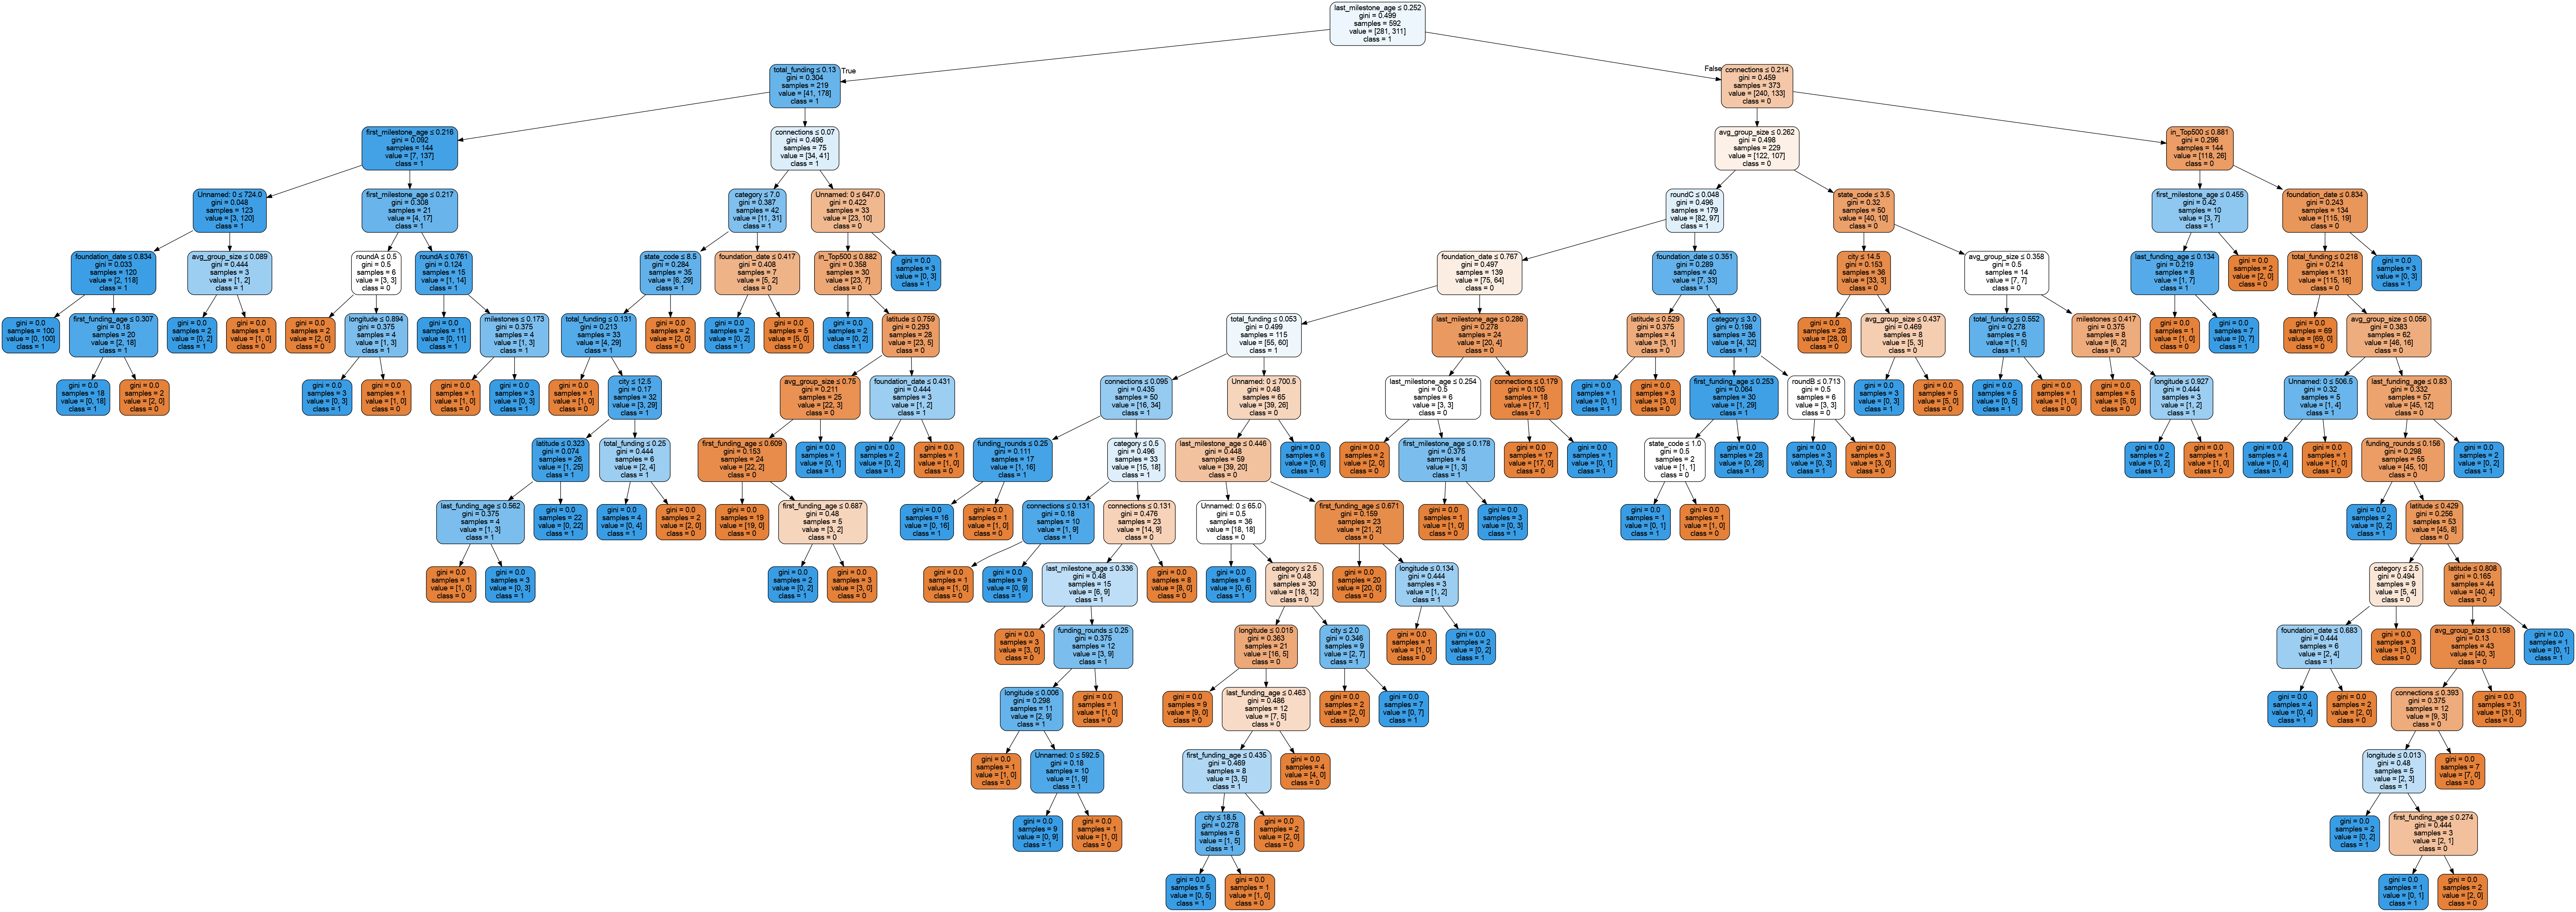

In [228]:
dot = export_graphviz(DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('./Pics/tree1.png')
Image(graph.create_png())

We can see in the DTC that it is overfitting, we will prove it with an example

In [229]:
y_train_pred = DTC.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_pred))
pd.DataFrame(metrics.confusion_matrix(y_train, y_train_pred))

1.0


,0,1
0,281,0
1,0,311


We will now change the DTC parameters so it wont overfit and we will find the one with maximun accuracy

min_samples_leaf: 15, accuracy: 0.7676767676767676


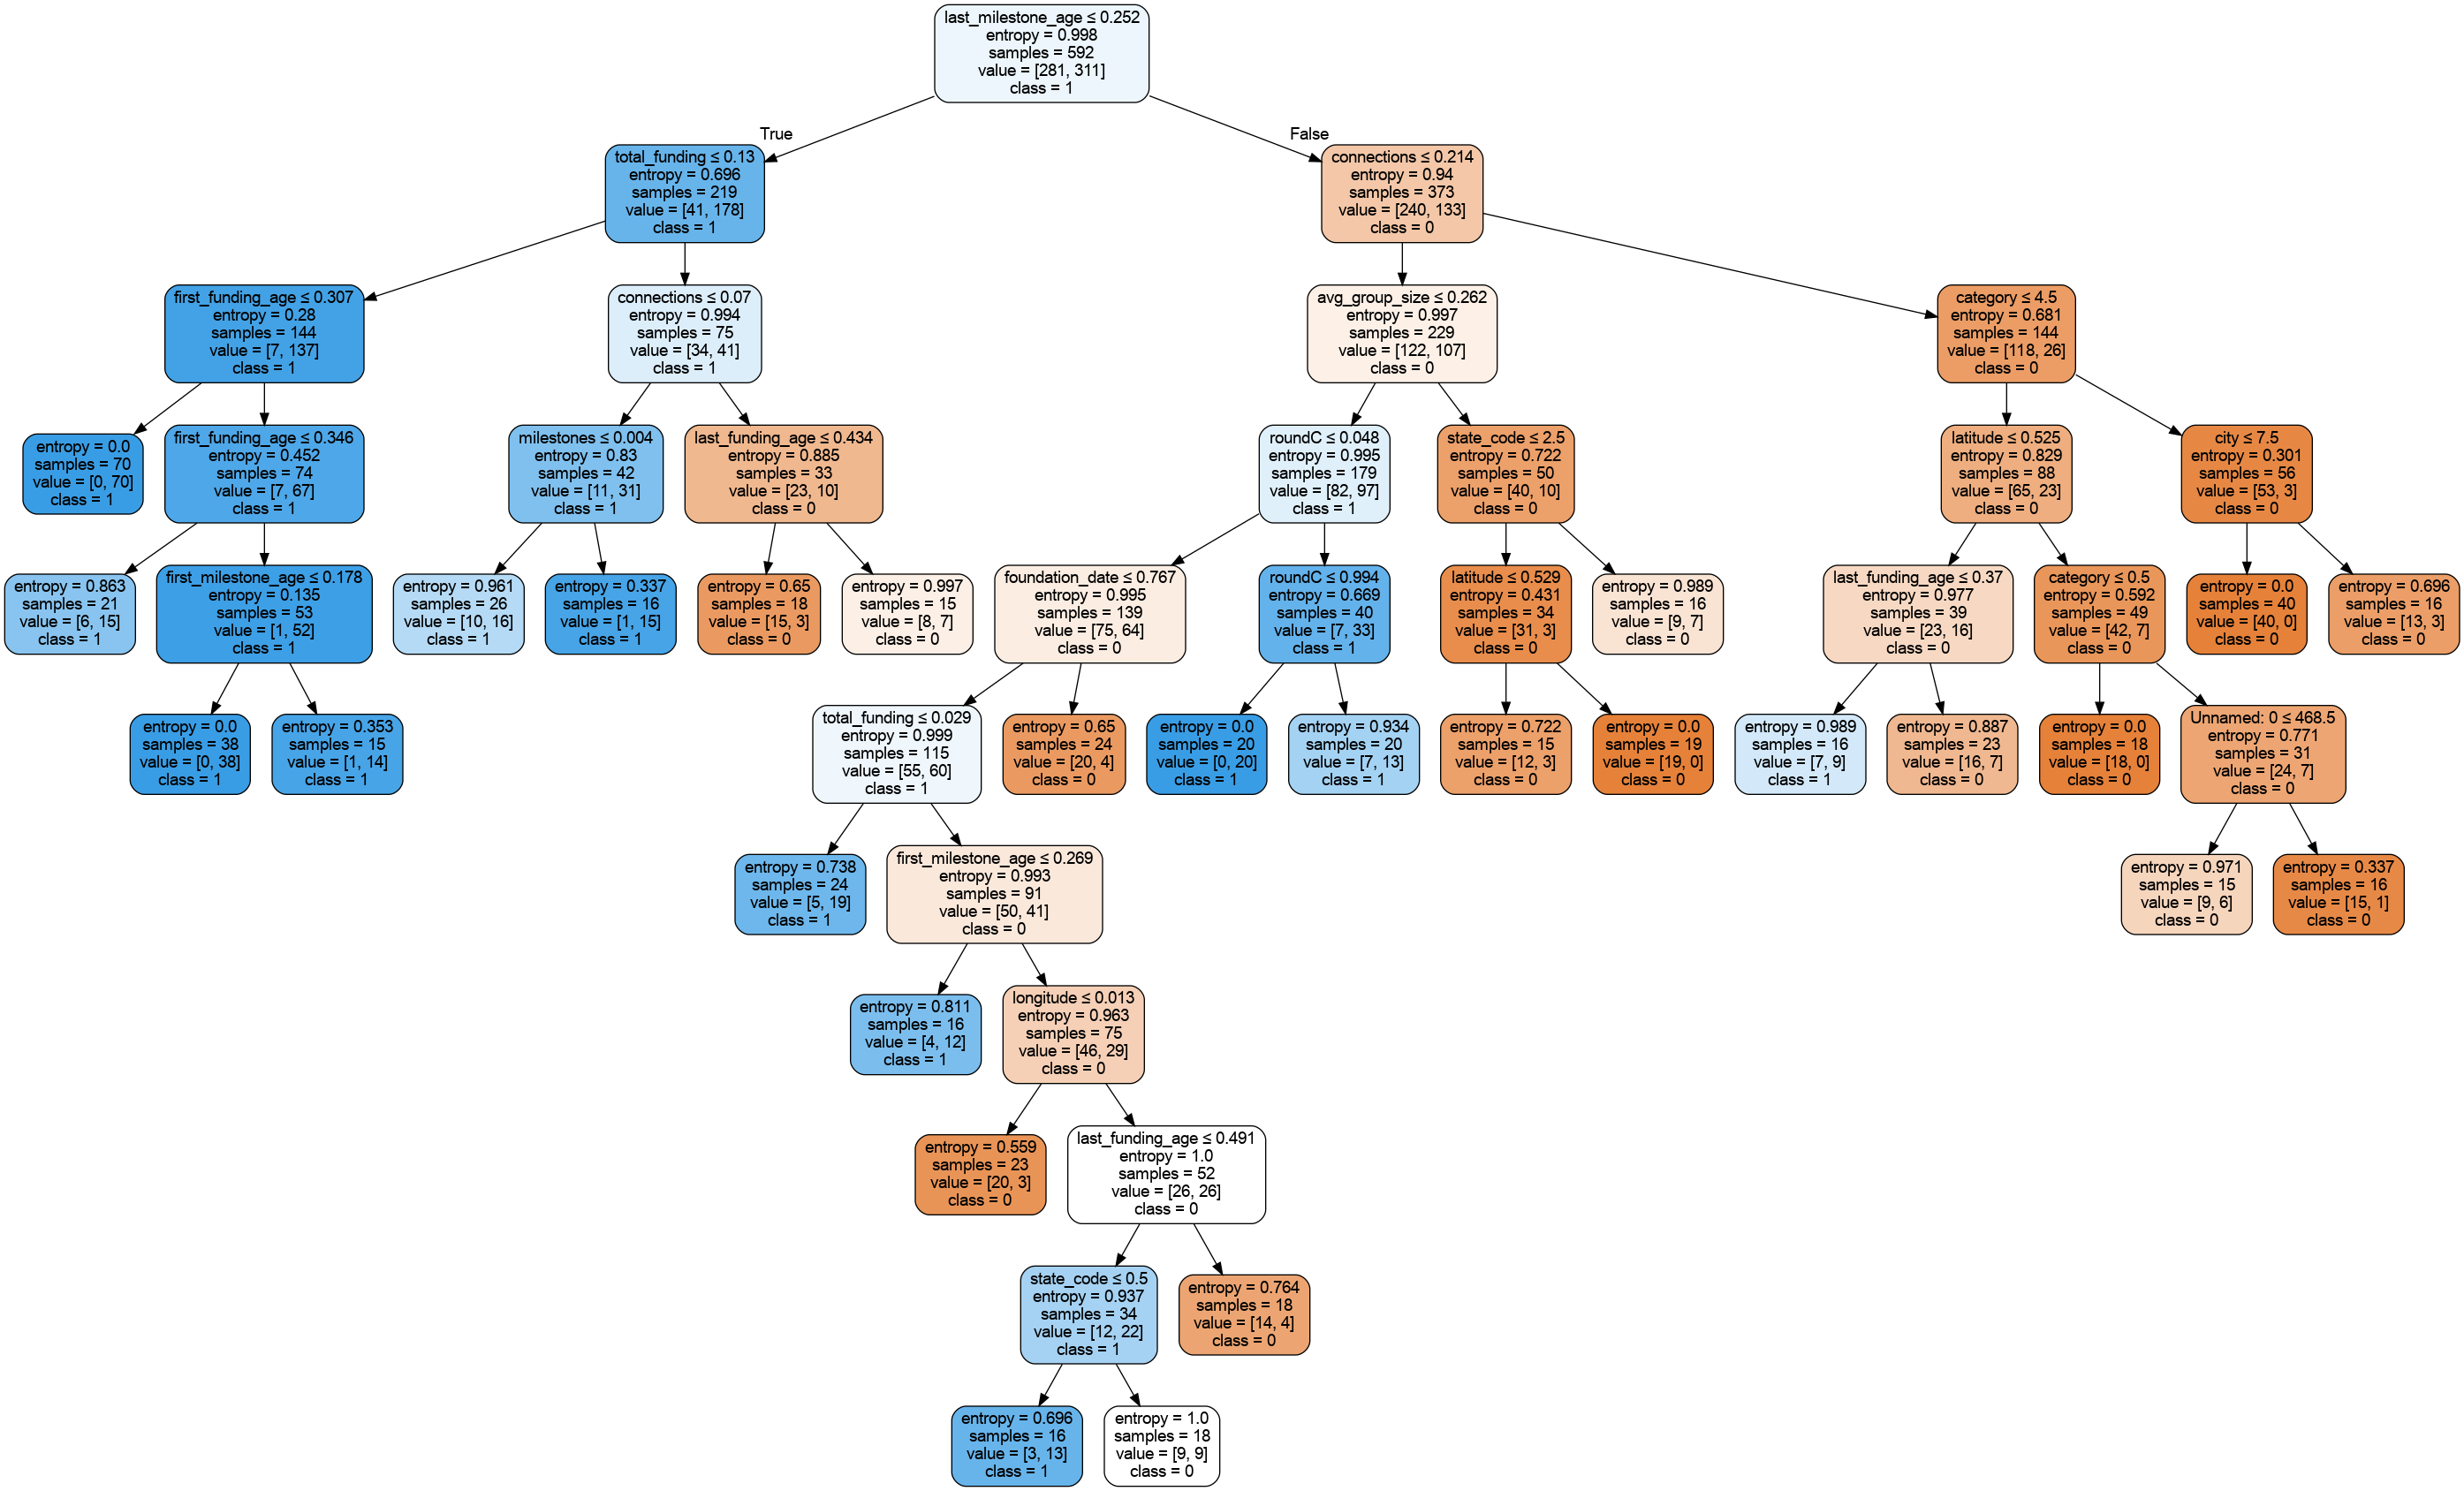

In [230]:
best_min_samples_leaf = 1
best_accuracy = 0
accuracies = []
best_DTC = None
for min_samples_leaf in range(1,50):
    DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 
    DTC2 = DTC2.fit(X_train,y_train)
    y_pred = DTC2.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
            
print(f'min_samples_leaf: {best_min_samples_leaf}, accuracy: {best_accuracy}')

dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
graph.write_png('./Pics/tree2.png')
Image(graph.create_png())

We saw that min_samples_leaf 32 is the best in accuracy and preventing overfitting, but now we want to test if its true for kFolds splitting and not only one validation split of the data

In [231]:
best_min_samples_leaf = 1
best_precision = 0
best_accuracy = 0
accuracies = []
precisions = []
best_DTC = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train = training_df.to_numpy()
for min_samples_leaf in range(1,50):
    cm = []
    precision = []
    for train_index, test_index in kf.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = y[train_index], y[test_index]

        DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 

        DTC2.fit(X_train, y_train)
        y_pred = DTC2.predict(X_test)
        cm.append(metrics.confusion_matrix(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average='weighted'))

    result_cm = np.zeros((2,2))
    for matrix in cm:
        result_cm += matrix
    result_cm = result_cm/len(cm)
    acc = (result_cm[0][0]+result_cm[1][1])/(result_cm[0][0]+result_cm[0][1]+result_cm[1][0]+result_cm[1][1])
    prs = np.average(precision)

    accuracies.append(acc)
    precisions.append(prs)
    if acc > best_accuracy:
            best_accuracy = acc
            best_precision = prs
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
print(f'min_samples_leaf: {best_min_samples_leaf}, precision: {best_precision}, acuurecy: {best_accuracy}')



min_samples_leaf: 18, precision: 0.7418220889389283, acuurecy: 0.7379746835443037


we want to see the graphs of the accurecy and presicion as a function of the min_samples_tree to choose the best parameter

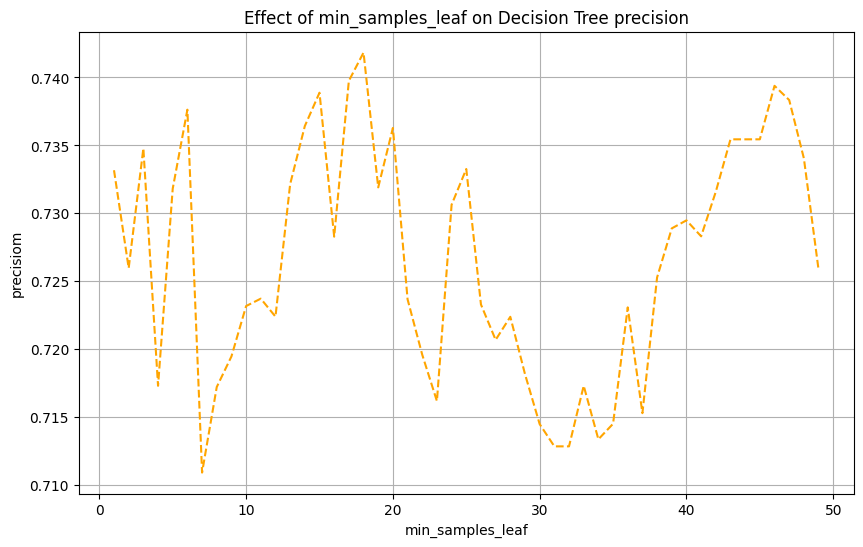

In [232]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, 50), precisions, linestyle='--', color='orange')

ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('precisiom')
ax.set_title('Effect of min_samples_leaf on Decision Tree precision')
ax.grid()
plt.show()

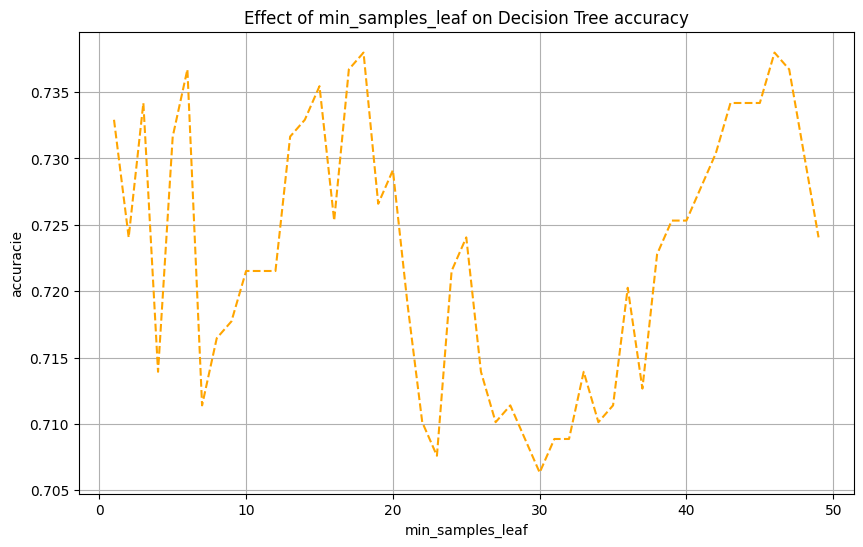

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, 50), accuracies, linestyle='--', color='orange')

ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('accuracie')
ax.set_title('Effect of min_samples_leaf on Decision Tree accuracy')
ax.grid()
plt.show()

We noticed that min_samples_leaf = 20 is the best parameter as its not overfittinh and as the highest accurecy and very close to the highest precision, we will show the DTC

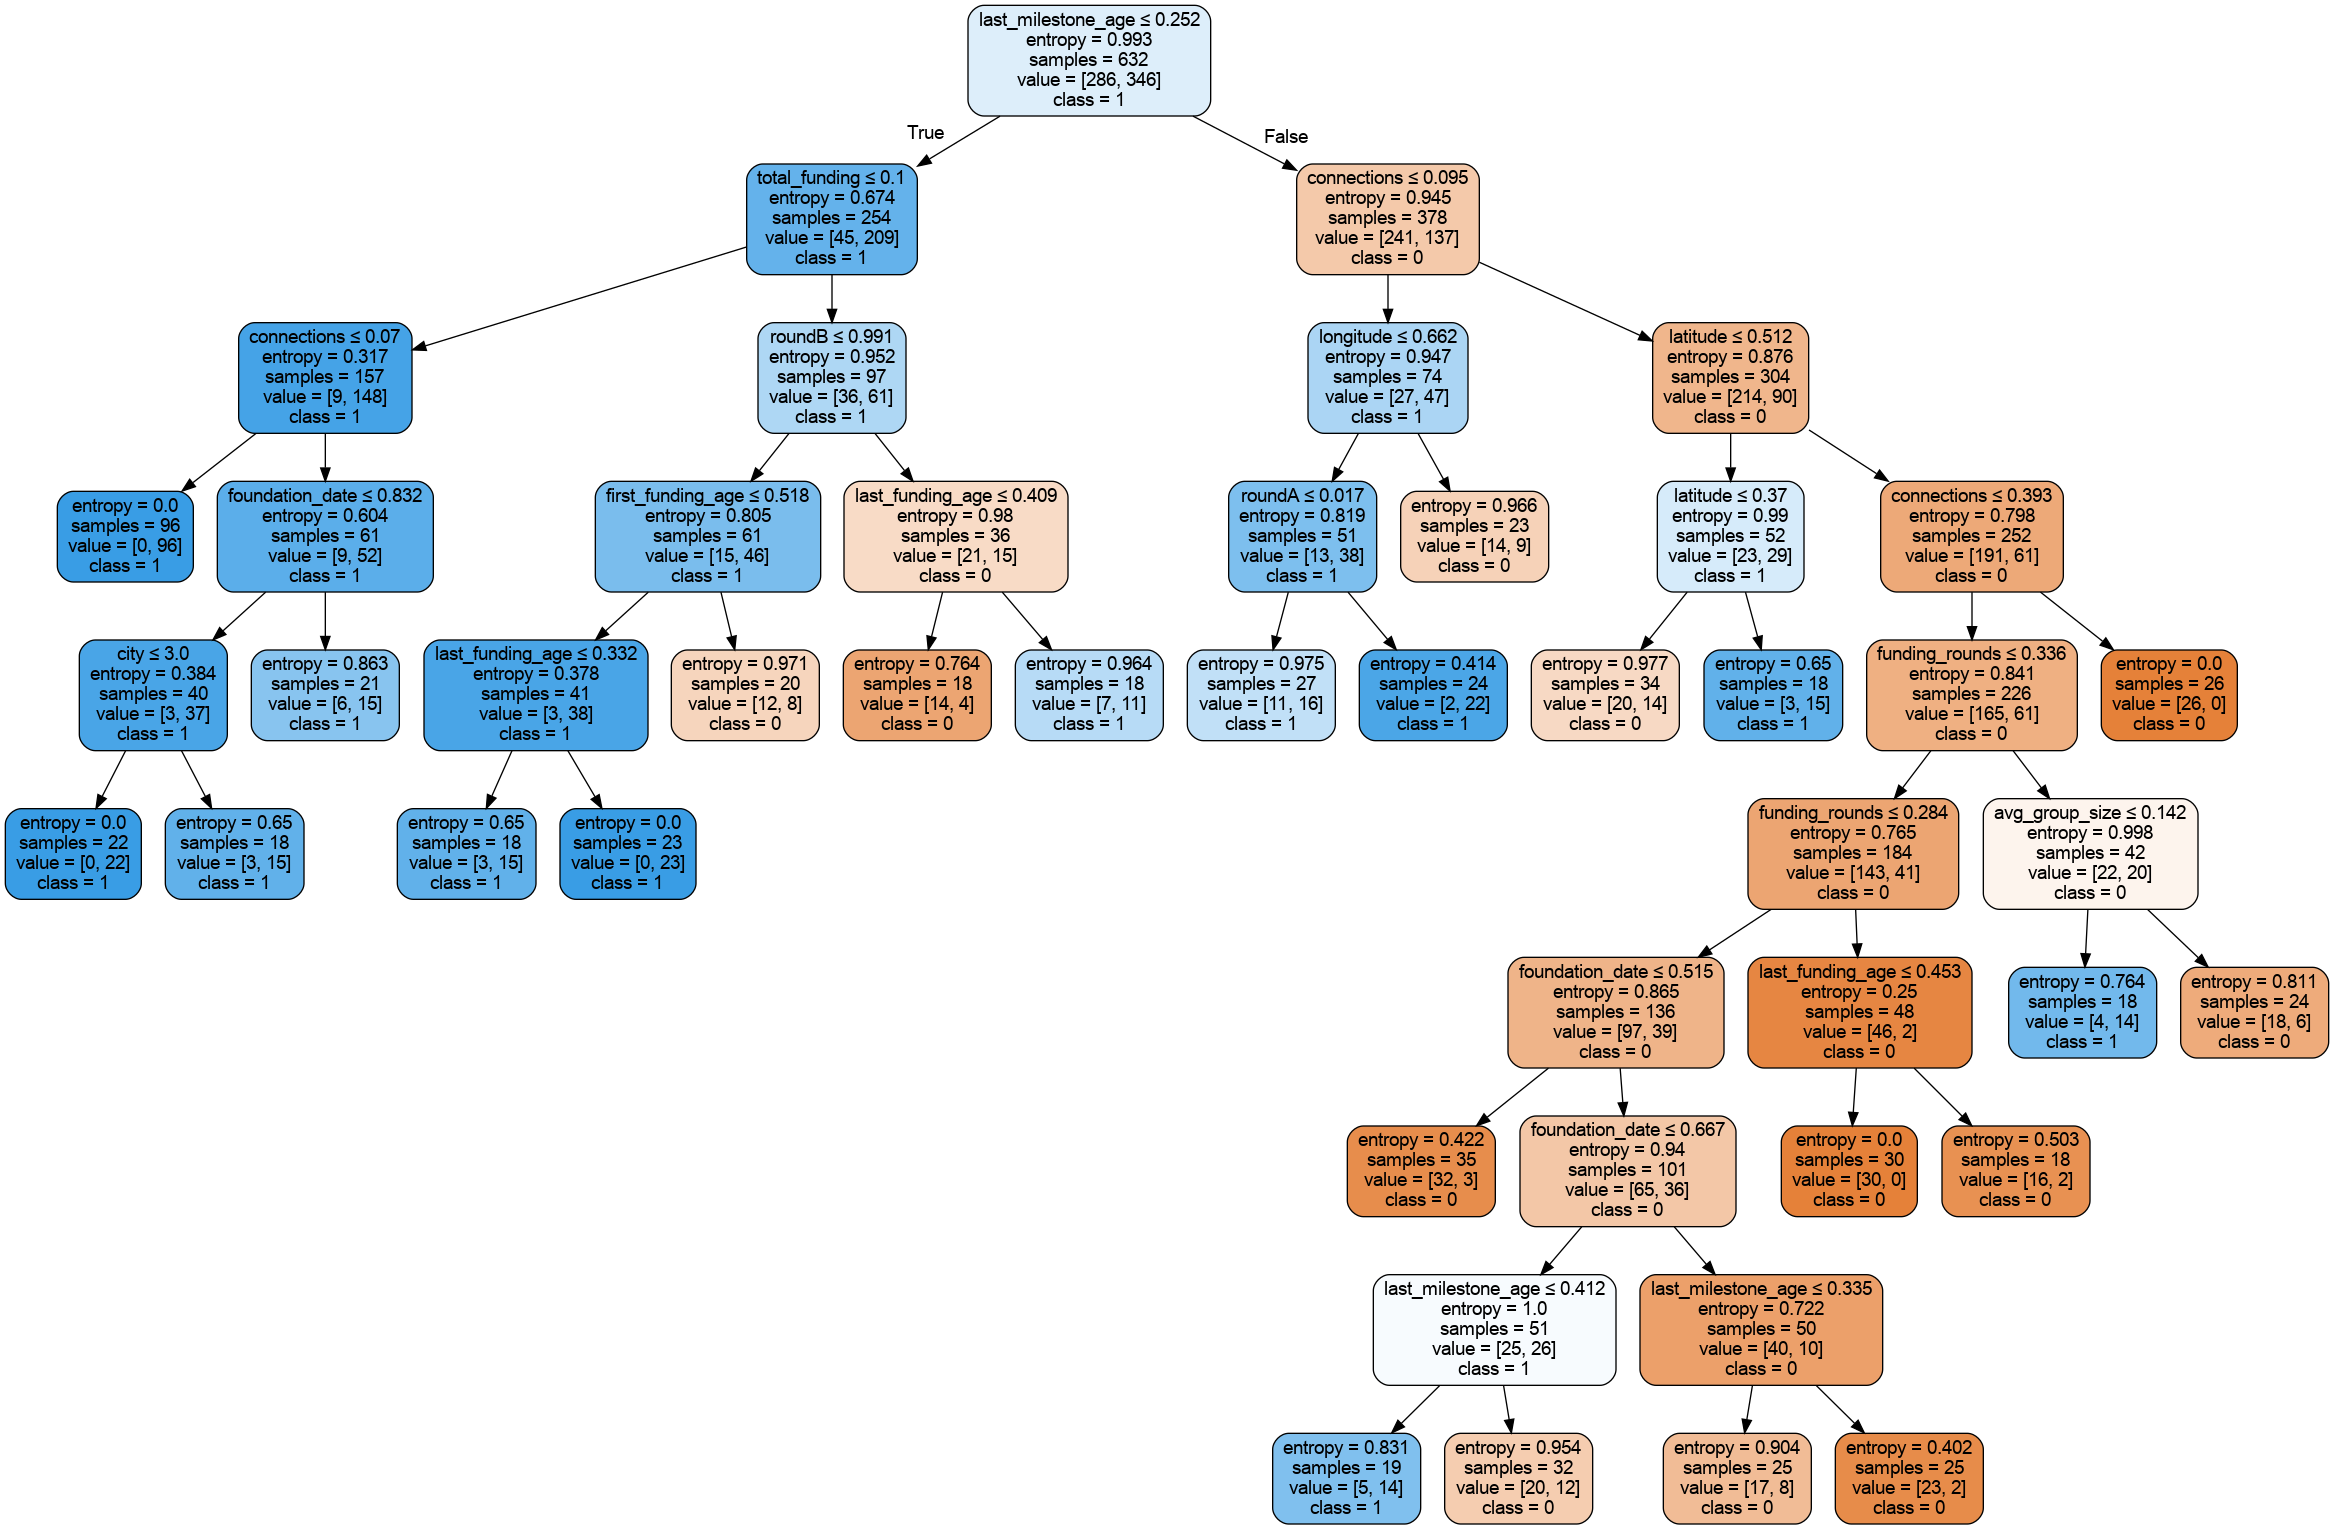

In [234]:
dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
graph.write_png('./Pics/tree2.png')
Image(graph.create_png())

Pruning - didnt work out

In [235]:
# path = DTC2.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas = path.ccp_alphas
# accuracies = []
# for i in ccp_alphas:
#     pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=i, min_samples_leaf = 32)
#     pruned_classifier.fit(X_train, y_train)
#     y_pred = pruned_classifier.predict(X_test)
#     accuracy = metrics.accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)
#     print("Best alpha for pruning:", i)
#     print("Accuracy after pruning:", accuracy)
    
# # Choose the best ccp_alpha that maximizes the accuracy
# best_alpha = ccp_alphas[np.argmax(accuracies)]
# pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha, min_samples_leaf = 32)
# pruned_classifier.fit(X_train, y_train)
# y_pred = pruned_classifier.predict(X_test)
# accuracy_after_pruning = metrics.accuracy_score(y_test, y_pred)
# print("Best alpha for pruning:", best_alpha)
# print("Accuracy after pruning:", accuracy_after_pruning)

# dot = export_graphviz(pruned_classifier, filled=True, rounded=True, 
#                 special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot)
# graph.write_png('./Pics/tree2.png')
# Image(graph.create_png())